In [ ]:
import Pkg
Pkg.add("ITensors")
Pkg.add("NPZ")
Pkg.add("GLM")
Pkg.add("Plots")

In [2]:

using ITensors
using Pkg
using NPZ

In [10]:

N = 32

# Make an array of N Index objects with alternating
# "S=1/2" and "S=1" tags on odd versus even sites
# (The first argument n->isodd(n) ... is an 
# on-the-fly function mapping integers to strings)

sites = siteinds("S=1/2", N)
entangle_E = []
pa = []
P0_list = []
P1_list = []
i = 2
b = 2
angle_list = [0.0,  0.05*pi, 0.1*pi, 0.15*pi, 0.2*pi, 0.25*pi, 0.3*pi, 0.35*pi, 0.4*pi, 0.45*pi, 0.5*pi]
ITensors.op(::OpName"P0",::SiteType"S=1/2") =
 [1 0
  0 0]
ITensors.op(::OpName"P1",::SiteType"S=1/2") =
 [0 0
  0 1]

for angle in angle_list
    all_tensors = []
    
    # The Hamiltonian for the rotated cluster state
    os = OpSum()
    os -= 4.0*cos(angle)^2, "Sz",1,"Sx",2
    os -= 4.0*cos(angle)*sin(angle), "Sz",1,"Sz",2
    os += 4.0*sin(angle)^2, "Sx",1,"Sz",2
    os += 4.0*cos(angle)*sin(angle), "Sx",1,"Sx",2
    
    os -= 8.0*cos(angle)^3, "Sx", N-2,"Sz",N-1,"Sz",N
    os -= 8.0*cos(angle)^2*sin(angle), "Sz",N-2,"Sz",N-1, "Sz",N
    os += 8.0*cos(angle)^2*sin(angle), "Sx",N-2,"Sx",N-1, "Sz",N
    os += 8.0*cos(angle)^2*sin(angle), "Sx",N-2,"Sz",N-1, "Sx",N
    os += 8.0*cos(angle)*sin(angle)^2, "Sz",N-2,"Sx",N-1, "Sz",N
    os += 8.0*cos(angle)*sin(angle)^2, "Sz",N-2,"Sz",N-1, "Sx",N
    os -= 8.0*cos(angle)*sin(angle)^2, "Sx",N-2,"Sx",N-1, "Sx",N
    os -= 8.0*sin(angle)^3, "Sz",N-2,"Sx",N-1, "Sx",N
    
    os -= 4.0*cos(angle)^2, "Sx", N-1,"Sx",N
    os -= 4.0*cos(angle)*sin(angle), "Sx", N-1,"Sz",N
    os -= 4.0*sin(angle)^2, "Sz", N-1,"Sz",N
    os -= 4.0*cos(angle)*sin(angle), "Sz", N-1,"Sx",N
    
    for j=1:N-3
        os -= 8.0*cos(angle)^3, "Sx",j,"Sz",j+1,"Sx",j+2
        os -= 8.0*cos(angle)^2*sin(angle), "Sz",j,"Sz",j+1, "Sx", j+2
        os += 8.0*cos(angle)^2*sin(angle), "Sx",j,"Sx",j+1, "Sx", j+2
        os -= 8.0*cos(angle)^2*sin(angle), "Sx",j,"Sz",j+1,"Sz", j+2
        os += 8.0*cos(angle)*sin(angle)^2, "Sz",j,"Sx",j+1, "Sx", j+2
        os += 8.0*cos(angle)*sin(angle)^2, "Sx",j,"Sx",j+1, "Sz", j+2
        os -= 8.0*cos(angle)*sin(angle)^2, "Sz",j,"Sz",j+1,"Sz", j+2
        os += 8.0*sin(angle)^3, "Sz",j,"Sx",j+1,"Sz", j+2
    end
    H = MPO(os, sites)
    # DMRG setup
    nsweeps = 5
    maxdim = [10,20,40,80,200]
    mindim = [2, 2, 2, 2, 2]
    cutoff = [1E-6]
    noise = [1E-5, 1E-6, 1E-7, 1E-8, 0.0]
    psi0 = randomMPS(sites, 10)
    ang = round(angle, digits = 3)
    energy, psi = dmrg(H, psi0; nsweeps, maxdim, mindim, cutoff, noise)
    
    # Save the initial tensor as an .npy file
    # First matrix
    save_dir = "mps_tensors"
    isdir(save_dir) || mkdir(save_dir)  # Create the directory if it doesn't exist 
    tensor = psi[1]
    tensor_array = Array(tensor, siteinds(psi, 1), linkinds(psi, 1))  # Convert the ITensor to a dense array
    file_path = joinpath(save_dir, "ES_tensor_init_$(N)_angle_$(ang).npy")  # File path for the .npy file
    npzwrite(file_path, tensor_array)  # Save the array as an .npy file
    
    # Iterate over each site in the MPS and save the tensor as an .npy file
    for i in 2:length(psi)-1
        tensor = psi[i] # Convert the ITensor to a dense array
        tensor_array = Array(tensor, siteinds(psi, i), linkinds(psi, i), linkinds(psi, i-1))  # Convert the ITensor to a dense array
        push!(all_tensors, tensor_array) 
    end
    file_path = joinpath(save_dir, "ES_tensor_$(N)_angle_$(ang).npy")  # File path for the .npy file
    stacked_tensor = cat(all_tensors..., dims=ndims(all_tensors[1]) + 1)
    npzwrite(file_path, stacked_tensor)  # Save the array as an .npy file
    
    # Last matrix
    tensor = psi[length(psi)]
    tensor_array = Array(tensor, siteinds(psi, length(psi)), linkinds(psi, length(psi)-1))  # Convert the ITensor to a dense array
    file_path = joinpath(save_dir, "ES_tensor_last_$(N)_angle_$(ang).npy")  # File path for the .npy file
    npzwrite(file_path, tensor_array)  # Save the array as an .npy file
    
    # Sampling from the MPS 
    sample_array = [] 
    for i in 1:1024
        push!(sample_array, sample(psi))
    end
    sample_array = transpose(hcat(sample_array...))
    file_path = joinpath(save_dir, "ES_sample_$(N)_angle_$(ang).npy")  # File path for the .npy file
    npzwrite(file_path, Array(sample_array))  # Save the array as an .npy file
    
    # Measurement induced entanglement & CMI calculation
    normalize!(psi)
    for i in 2:12
        # Apply the projection operator to the MPS at site i
        entangle_Ei = 0
        for a in 1:2^(i-1)
            pa_i = 1
            ind = 2
            psi_i = deepcopy(psi)
            combination = digits(a - 1, base = 2, pad = i - 1)
            reverse!(combination)
            for com in combination
                if com == 0
                    new_psi_i = op("P0", sites[ind])*psi_i[ind]
                    noprime!(new_psi_i)
                    psi_i[ind] = new_psi_i
                    ind += 1
                else
                    new_psi_i = op("P1", sites[ind])*psi_i[ind]
                    noprime!(new_psi_i)
                    psi_i[ind] = new_psi_i
                    ind += 1 
                end
            end
            
            pa_i = inner(psi, psi_i)
             # Normalize the MPS
            if inner(psi, psi_i) > 1e-32
                normalize!(psi_i)
                orthogonalize!(psi_i, b)
                U,S,V = svd(psi_i[b], (linkind(psi_i, b-1), siteind(psi_i,b)))
                SvN = 0.0
                for n=1:dim(S, 1)
                    p = S[n,n]^2
                    SvN -= p * log(p+1e-32)
                end
                entangle_Ei += SvN*pa_i
            end
        end
        push!(entangle_E, entangle_Ei)
    end
end


After sweep 1 energy=-31.999743615724675  maxlinkdim=6 maxerr=7.93E-04 time=0.260
After sweep 2 energy=-32.000000000000014  maxlinkdim=2 maxerr=3.46E-08 time=0.031
After sweep 3 energy=-31.999999999999982  maxlinkdim=2 maxerr=7.77E-16 time=0.026
After sweep 4 energy=-32.00000000000002  maxlinkdim=2 maxerr=5.55E-16 time=0.028
After sweep 5 energy=-32.0  maxlinkdim=2 maxerr=6.66E-16 time=0.157
After sweep 1 energy=-31.999642107721566  maxlinkdim=4 maxerr=9.41E-04 time=0.028
After sweep 2 energy=-31.999999999999986  maxlinkdim=2 maxerr=1.09E-08 time=0.022
After sweep 3 energy=-32.00000000000006  maxlinkdim=2 maxerr=6.66E-16 time=0.026
After sweep 4 energy=-32.00000000000004  maxlinkdim=2 maxerr=6.66E-16 time=0.024
After sweep 5 energy=-32.00000000000005  maxlinkdim=2 maxerr=5.55E-16 time=0.022
After sweep 1 energy=-31.999887378838068  maxlinkdim=4 maxerr=9.92E-04 time=0.028
After sweep 2 energy=-32.000000000000014  maxlinkdim=2 maxerr=2.60E-09 time=0.023
After sweep 3 energy=-31.999999999

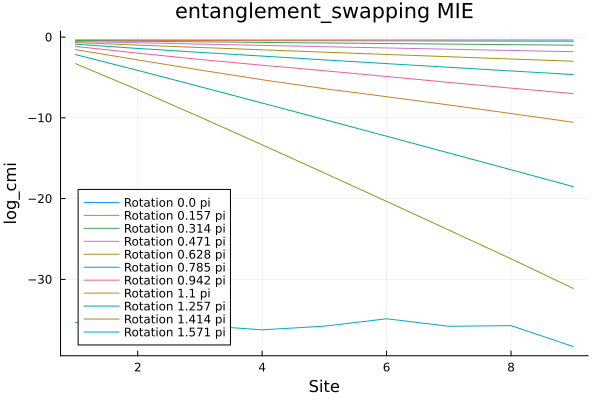

In [11]:
using Plots
reshaped_array = reshape(log.(abs.(entangle_E)), 11, 11)'
# Number of lines (rows of the array)
num_lines = size(reshaped_array, 1)

# Create a plot with multiple lines
p = plot()
for i in 1:num_lines
    angle = round(angle_list[i], digits = 3)
    plot!(1:size(reshaped_array, 2)-2, reshaped_array[i, 1 : end-2], label = "Rotation $angle pi")
end
xlabel!(p, "Site")
ylabel!(p, "log_cmi")
title!(p, "entanglement_swapping MIE")
# Display the plot
display(p)


In [12]:

using GLM

# Example data
x = [1,2,3,4,5,6,7,8,9,10,11]  # Predictor variable
X = hcat(ones(length(x)), x)
slope_list = []
slope_error_list = []
for i in 1:length(angle_list)-1
    y = reshaped_array[i, :]    # Response variable
    model = lm(X, y)

    # Get standard errors of the coefficients
    coefficients = coef(model)
    coeff_errors = stderror(model)
    
    # The standard error of the slope is the second element
    slope = coefficients[2]
    slope_error = coeff_errors[2]
    
    println("Slope: ", slope)
    println("Standard error of the slope: ", slope_error)
    push!(slope_list, slope)
    push!(slope_error_list, slope_error)
end

Slope: -2.280221030961003e-15
Standard error of the slope: 1.2014987602829158e-15
Slope: -0.017675824671816227
Standard error of the slope: 1.9379276431925045e-5
Slope: -0.06999523713582509
Standard error of the slope: 0.0002095999227862594
Slope: -0.1575335568654368
Standard error of the slope: 0.0007067328993859084
Slope: -0.28495733075884727
Standard error of the slope: 0.0015825704795772195
Slope: -0.46249046468814914
Standard error of the slope: 0.0030419692828615717
Slope: -0.7149956958765349
Standard error of the slope: 0.005691503652305405
Slope: -1.0957841645839588
Standard error of the slope: 0.01322166219373558
Slope: -2.059487860229082
Standard error of the slope: 0.00615146895380645
Slope: -3.2881156372788922
Standard error of the slope: 0.09959219839000549


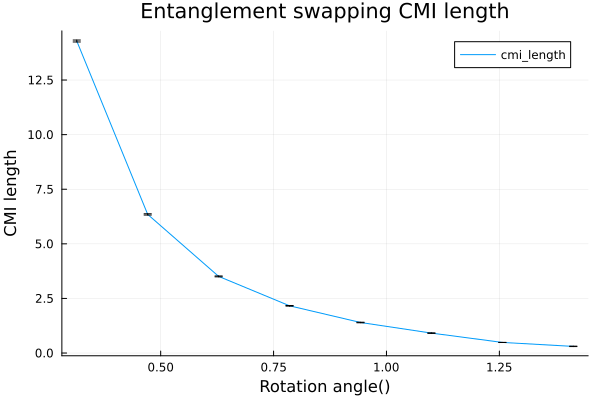

In [13]:
p = plot(angle_list[3:end-1], -1 ./ slope_list[3:end], yerr = (1 ./ slope_list[3:end]).^2 .* slope_error_list[3:end], label = "cmi_length")
xlabel!(p, "Rotation angle()")
ylabel!(p, "CMI length")
title!(p, "Entanglement swapping CMI length")

In [20]:

N = 64

# Make an array of N Index objects with alternating
# "S=1/2" and "S=1" tags on odd versus even sites
# (The first argument n->isodd(n) ... is an 
# on-the-fly function mapping integers to strings)

sites = siteinds("S=1/2", N)
entangle_E = []
pa = []
N = 64
i = 2
b = 2
P0_list = []
P1_list = []
angle_list = [0.0, 0.05*pi, 0.1*pi, 0.15*pi, 0.2*pi, 0.25*pi, 0.3*pi, 0.35*pi, 0.4*pi, 0.45*pi, 0.5*pi]

ITensors.op(::OpName"P0",::SiteType"S=1/2") =
 [1 0
  0 0]
ITensors.op(::OpName"P1",::SiteType"S=1/2") =
 [0 0
  0 1]

for angle in angle_list
    ang = round(angle, digits = 3)
    all_tensors = []
    os = OpSum()
    os -= 4.0*cos(angle)^2, "Sx",1,"Sz",2
    os -= 4.0*cos(angle)*sin(angle), "Sz",1,"Sz",2
    os += 4.0*sin(angle)^2, "Sz",1,"Sx",2
    os += 4.0*cos(angle)*sin(angle), "Sx",1,"Sx",2
    
    os -= 4.0*cos(angle)^2, "Sz", N-1,"Sx",N
    os -= 4.0*cos(angle)*sin(angle), "Sz", N-1,"Sz",N
    os += 4.0*sin(angle)^2, "Sx", N-1,"Sz",N
    os += 4.0*cos(angle)*sin(angle), "Sx", N-1,"Sx",N
    
    for j=1:N-2
        os -= 8.0*cos(angle)^3, "Sz",j,"Sx",j+1,"Sz",j+2
        os += 8.0*cos(angle)^2*sin(angle), "Sx",j,"Sx",j+1, "Sz", j+2
        os -= 8.0*cos(angle)^2*sin(angle), "Sz",j,"Sz",j+1, "Sz", j+2
        os += 8.0*cos(angle)^2*sin(angle), "Sz",j,"Sx",j+1,"Sx", j+2
        os += 8.0*cos(angle)*sin(angle)^2, "Sx",j,"Sz",j+1, "Sz", j+2
        os += 8.0*cos(angle)*sin(angle)^2, "Sz",j,"Sz",j+1, "Sx", j+2
        os -= 8.0*cos(angle)*sin(angle)^2, "Sx",j,"Sx",j+1,"Sx", j+2
        os -= 8.0*sin(angle)^3, "Sx",j,"Sz",j+1,"Sx", j+2
    end
    

    H = MPO(os,sites)

    nsweeps = 5
    maxdim = [10,10,10,10,10]
    cutoff = [1E-6]
    noise = [1E-5, 1E-6, 1E-7, 1E-8, 0.0]
    psi0 = randomMPS(sites,10)

    energy, psi = dmrg(H, psi0; nsweeps, maxdim, cutoff, noise)
    
    # Save the initial tensor as an .npy file
    # First matrix
    save_dir = "mps_tensors"
    isdir(save_dir) || mkdir(save_dir)  # Create the directory if it doesn't exist 
    tensor = psi[1]
    tensor_array = Array(tensor, siteinds(psi, 1), linkinds(psi, 1))  # Convert the ITensor to a dense array
    file_path = joinpath(save_dir, "cluster_tensor_init_$(N)_angle_$(ang).npy")  # File path for the .npy file
    npzwrite(file_path, tensor_array)  # Save the array as an .npy file
    
    # Iterate over each site in the MPS and save the tensor as an .npy file
    for i in 2:length(psi)-1
        tensor = psi[i] # Convert the ITensor to a dense array
        tensor_array = Array(tensor, siteinds(psi, i), linkinds(psi, i), linkinds(psi, i-1))  # Convert the ITensor to a dense array
        push!(all_tensors, tensor_array) 
    end
    file_path = joinpath(save_dir, "cluster_tensor_$(N)_angle_$(ang).npy")  # File path for the .npy file
    stacked_tensor = cat(all_tensors..., dims=ndims(all_tensors[1]) + 1)
    npzwrite(file_path, stacked_tensor)  # Save the array as an .npy file
    
    # Last matrix
    tensor = psi[length(psi)]
    tensor_array = Array(tensor, siteinds(psi, length(psi)), linkinds(psi, length(psi)-1))  # Convert the ITensor to a dense array
    file_path = joinpath(save_dir, "cluster_tensor_last_$(N)_angle_$(ang).npy")  # File path for the .npy file
    npzwrite(file_path, tensor_array)  # Save the array as an .npy file
    
    # Sampling from the MPS 
    sample_array = [] 
    for i in 1:1024
        push!(sample_array, sample(psi))
    end
    sample_array = transpose(hcat(sample_array...))
    file_path = joinpath(save_dir, "ES_sample_$(N)_angle_$(ang).npy")  # File path for the .npy file
    npzwrite(file_path, Array(sample_array))  # Save the array as an .npy file
    
    for i in 2:12
        # Apply the projection operator to the MPS at site i
        entangle_Ei = 0
        for a in 1:2^(i-1)
            pa_i = 1
            ind = 2
            psi_i = deepcopy(psi)
            combination = digits(a-1, base = 2, pad = i - 1)
            reverse!(combination)
            for com in combination
                if com == 0
                    new_psi_i = op("P0", sites[ind])*psi_i[ind]
                    noprime!(new_psi_i)
                    psi_i[ind] = new_psi_i
                    ind += 1
                else
                    new_psi_i = op("P1", sites[ind])*psi_i[ind]
                    noprime!(new_psi_i)
                    psi_i[ind] = new_psi_i
                    ind += 1 
                end
            end
            
            pa_i = inner(psi, psi_i)
            
             # Normalize the MPS
            if inner(psi, psi_i) > 1e-20
                normalize!(psi_i)
                orthogonalize!(psi_i, b)
                U,S,V = svd(psi_i[b], (linkind(psi_i, b-1), siteind(psi_i,b)))
                SvN = 0.0
                for n=1:dim(S, 1)
                    p = S[n,n]^2
                    SvN -= p * log(p+1e-32)
                end
                entangle_Ei += SvN*pa_i
            end
        end
        push!(entangle_E, entangle_Ei)
    end
end


After sweep 1 energy=-63.99962144060554  maxlinkdim=4 maxerr=9.84E-04 time=0.068
After sweep 2 energy=-63.999999999999915  maxlinkdim=2 maxerr=1.33E-09 time=0.049
After sweep 3 energy=-63.99999999999991  maxlinkdim=2 maxerr=6.66E-16 time=0.059
After sweep 4 energy=-64.00000000000011  maxlinkdim=2 maxerr=7.77E-16 time=0.058
After sweep 5 energy=-64.00000000000043  maxlinkdim=2 maxerr=5.55E-16 time=0.053
After sweep 1 energy=-63.99961869234818  maxlinkdim=3 maxerr=9.49E-04 time=0.058
After sweep 2 energy=-63.999999999999986  maxlinkdim=2 maxerr=3.20E-09 time=0.049
After sweep 3 energy=-64.00000000000016  maxlinkdim=2 maxerr=5.55E-16 time=0.045
After sweep 4 energy=-63.99999999999994  maxlinkdim=2 maxerr=6.66E-16 time=0.050
After sweep 5 energy=-63.99999999999998  maxlinkdim=2 maxerr=7.77E-16 time=0.045
After sweep 1 energy=-63.99923936380126  maxlinkdim=4 maxerr=1.28E-03 time=0.059
After sweep 2 energy=-63.999999999999936  maxlinkdim=2 maxerr=1.10E-08 time=0.048
After sweep 3 energy=-64.

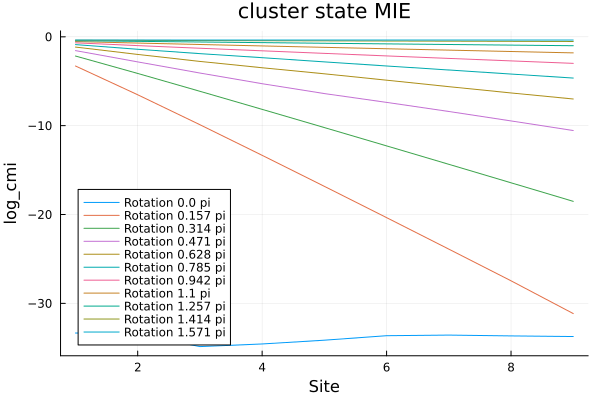

In [54]:
reshaped_array = reshape(log.(abs.(entangle_E)), 11, 11)'
# Number of lines (rows of the array)
num_lines = size(reshaped_array, 1)

# Create a plot with multiple lines
p = plot()
for i in 1:num_lines
    angle = round(angle_list[i], digits = 3)
    plot!(1:size(reshaped_array, 2)-2, reshaped_array[i, 1 : end-2], label = "Rotation $angle pi")
end
xlabel!(p, "Site")
ylabel!(p, "log_cmi")
title!(p, "cluster state MIE")
# Display the plot
display(p)

In [56]:

using GLM

# Example data
x = [1,2,3,4,5,6,7,8,9,10,11]  # Predictor variable
X = hcat(ones(length(x)), x)
slope_list = []
slope_error_list = []
for i in 1:length(angle_list)-1
    y = reshaped_array[i, :]    # Response variable
    model = lm(X, y)

    # Get standard errors of the coefficients
    coefficients = coef(model)
    coeff_errors = stderror(model)
    
    # The standard error of the slope is the second element
    slope = coefficients[2]
    slope_error = coeff_errors[2]
    
    println("Slope: ", slope)
    println("Standard error of the slope: ", slope_error)
    push!(slope_list, slope)
    push!(slope_error_list, slope_error)
end

Slope: 0.022678469265668126
Standard error of the slope: 0.04717933253084055
Slope: -3.265777543955485
Standard error of the slope: 0.10664943868812957
Slope: -2.0594869479643485
Standard error of the slope: 0.0061512174862369835
Slope: -1.0957841646359
Standard error of the slope: 0.013221662185476036
Slope: -0.7149956958769914
Standard error of the slope: 0.005691503652224405
Slope: -0.46249046468816224
Standard error of the slope: 0.0030419692828603053
Slope: -0.2849573307588434
Standard error of the slope: 0.0015825704795778463
Slope: -0.15753355686543763
Standard error of the slope: 0.0007067328993857006
Slope: -0.06999523713582505
Standard error of the slope: 0.00020959992278626907
Slope: -0.01767582467181615
Standard error of the slope: 1.9379276431939725e-5


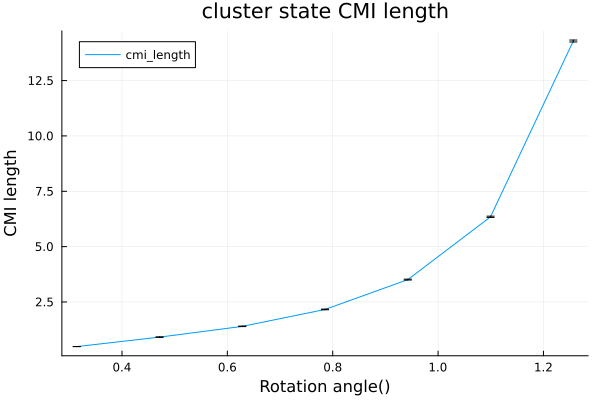

In [57]:
p = plot(angle_list[3:end-2], -1 ./ slope_list[3:end-1], yerr = (1 ./ slope_list[3:end-1]).^2 .* slope_error_list[3:end-1], label = "cmi_length")
xlabel!(p, "Rotation angle()")
ylabel!(p, "CMI length")
title!("cluster state CMI length")